The goal here is to evaluate the bit error rate introduced adversarial training by a bit-wise comparison of the original weight values with the modified values.

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
orig_weights = np.load('original_weights.npy')
modified_weights = np.load('modified_weights.npy')

In [4]:
def compute_minAndMax(list_arrays):
    '''
    Function to find the smallest and largest elements 
    in a list of numpy arrays
    '''
    min_val = np.inf
    max_val = -np.inf
    for arr in list_arrays:
        if arr.min() < min_val:
            min_val = arr.min()
        if arr.max() > max_val:
            max_val = arr.max()
    return min_val, max_val

In [5]:
def compute_scalingFunction(list_weightArrays, N) :
    """
    returns a function which scales the value to range 0-N,
    and is given by :
                N * (x - min)
        f(x) = ---------------
                  max - min
    """
    min_val, max_val = compute_minAndMax(list_weightArrays)
    print(min_val, max_val)
    return lambda x : N * (x - min_val)/(max_val - min_val)

In [6]:
def scale_weights(list_weightArrays, scale_func, N):
    """
    scale the weight values so that they are integers
    which can be manipulated with bitwise operators
    """
    list_scaledWeightArrays = []
    for arr in list_weightArrays:
        scaledArray = scale_func(arr)
        list_scaledWeightArrays.append(scaledArray.astype(int))
    return list_scaledWeightArrays

In [7]:
def compute_bitErrorRate(list_origWeights, list_modifiedWeights, N):
    '''
    scales the values to range 0-N, then computes the xor for each pair of values
    '''
    # We need to consider both the original weights as well as the modified 
    # weights while finding the minimum and maximum element, so that the 
    # computed range encompasses all the weight values.
    list_weightArrays = list_origWeights + list_modifiedWeights
    scale_func = compute_scalingFunction(list_weightArrays, N)
    scaled_origWeights = scale_weights(list_origWeights, scale_func, N)
    scaled_modifiedWeights = scale_weights(list_modifiedWeights, scale_func, N)
    list_bitErrorRates = []
    for orig_arr, modified_arr in zip(scaled_origWeights, scaled_modifiedWeights):
        # error_arr is the element-wise xor of all values in the array
        error_arr = orig_arr ^ modified_arr
        list_bitErrorRates.append(error_arr)
    return list_bitErrorRates

In [43]:
list_bitErrorRates = compute_bitErrorRate(orig_weights, modified_weights, 255)
# computation of bit error rates. By counting the number of 1s in a specific 
# bit position in the xor value, we can measure the bit error rate.
bitErrorRates = np.ndarray((7,8))
for layerNo, xor_arr in enumerate(list_bitErrorRates):
    for bitPos in range(8):
        mask = 2 ** bitPos
        and_arr = xor_arr & mask
        bitErrorRates[layerNo][bitPos] = np.mean(and_arr == mask)
print('Bit error rate values for all 7 layers for all 8 bit positions')
print(bitErrorRates)

-2.0573716 1.2827647
Bit error rate values for all 7 layers for all 8 bit positions
[[4.62962963e-03 2.31481481e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.05295139e-03 2.82118056e-03 9.76562500e-04 8.68055556e-04
  3.25520833e-04 2.17013889e-04 0.00000000e+00 0.00000000e+00]
 [5.64236111e-03 2.71267361e-03 1.30208333e-03 6.51041667e-04
  3.79774306e-04 1.62760417e-04 0.00000000e+00 0.00000000e+00]
 [7.13433160e-03 3.36371528e-03 1.73611111e-03 8.40928819e-04
  4.34027778e-04 2.71267361e-04 0.00000000e+00 0.00000000e+00]
 [8.69411892e-03 4.24533420e-03 2.14301215e-03 9.76562500e-04
  4.88281250e-04 3.52647569e-04 1.35633681e-05 1.35633681e-05]
 [3.96728516e-03 1.93786621e-03 9.46044922e-04 4.84466553e-04
  2.67028809e-04 2.13623047e-04 3.81469727e-06 3.81469727e-06]
 [3.12500000e-03 2.34375000e-03 1.56250000e-03 1.56250000e-03
  1.56250000e-03 1.56250000e-03 0.00000000e+00 0.00000000e+00]]


In [31]:
list_actualErrorValues = []
for orig_arr, modified_arr in zip(orig_weights, modified_weights):
        # error_arr is the element-wise difference of all values in the array
        error_arr = orig_arr - modified_arr
        list_actualErrorValues.append(error_arr)
compute_minAndMax(list_actualErrorValues)

(-0.0020616278, 0.0020405427)

In [40]:
def visualize(list_bitErrorRates, list_actualErrorValues):
    # Need to store as an array of arrays for plotting the values, a list
    # is not flexible enough
    flattened_bitErrorArrays = np.array([])
    for arr in list_bitErrorRates:
        flattened_bitErrorArrays = np.append(flattened_bitErrorArrays, np.reshape(arr, (-1,)))
    flattened_actualErrorArrays = np.array([])
    for arr in list_actualErrorValues:
        flattened_actualErrorArrays = np.append(flattened_actualErrorArrays, np.reshape(arr, (-1,)))
    print('histogram of actual noise values for all weight values')
    plt.hist(flattened_actualErrorArrays, 100)
    plt.show()
    #print('histogram of xor values for all weight values')
    #plt.hist(flattened_bitErrorArrays, 20)
    #plt.show()
    #plt.hist(flattened_actualErrorArrays, 100)
    #plt.show()
    #plt.hist(flattened_bitErrorArrays[flattened_bitErrorArrays > 0], 20)
    #plt.show()
    print('layer-wise distribution of the noise values')
    i = 1
    for actErr, bitErr in zip(list_actualErrorValues, list_bitErrorRates):
        actErr = np.reshape(actErr, (-1,))
        bitErr = np.reshape(bitErr, (-1,))
        print('Layer no. ', i)
        #plt.hist(actErr[actErr != 0], 20)
        plt.hist(actErr, 100)
        plt.show()
        #h = plt.hist(bitErr, 100)
        #plt.show()
        i += 1

histogram of actual noise values for all weight values


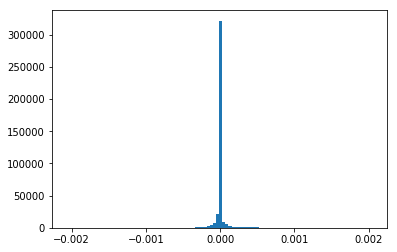

layer-wise distribution of the noise values
Layer no.  1


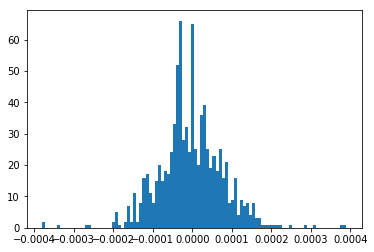

Layer no.  2


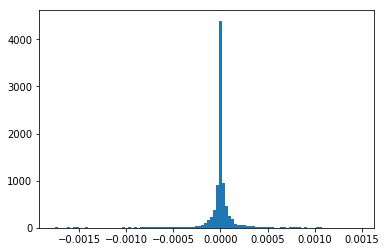

Layer no.  3


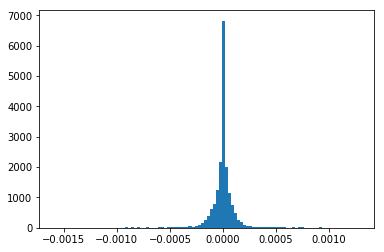

Layer no.  4


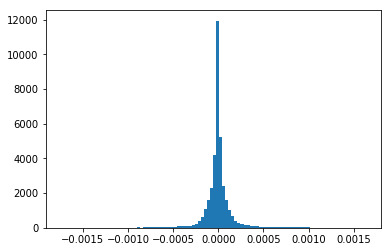

Layer no.  5


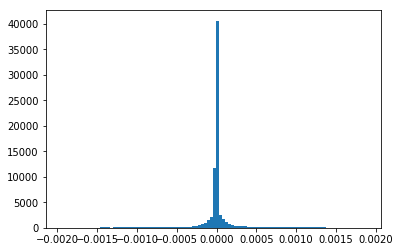

Layer no.  6


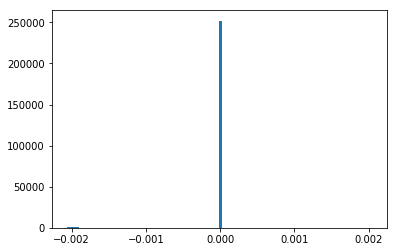

Layer no.  7


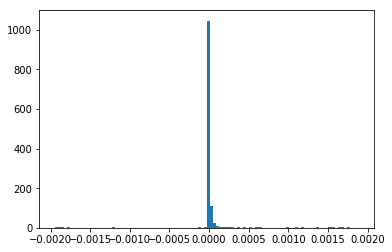

In [41]:
visualize(list_bitErrorRates, list_actualErrorValues)